In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


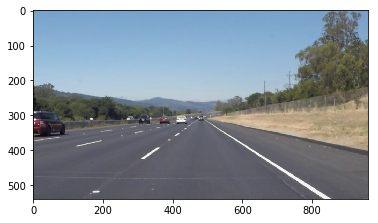

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=2)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_vertices(img, vertices, color=[0, 255, 0], thickness=2):
    """
    Draws vertices on top of the image with the fill poly function
    """
    vertices_in = vertices[0]
    cv2.line(img, (vertices_in[0][0], vertices_in[0][1]), (vertices_in[1][0], vertices_in[1][1]), color, thickness)
    cv2.line(img, (vertices_in[2][0], vertices_in[2][1]), (vertices_in[3][0], vertices_in[3][1]), color, thickness)
    
    return img

In [4]:
def detect_lanes_from_image_path(image_path, connected, **kwargs):
    # 1.) Load Image
    image = mpimg.imread(image_path)
    if connected:
        return detect_connected_lanes(image, **kwargs)
    else:
        return detect_lanes(image, **kwargs)
    
def detect_lanes(image, blur_kernel_size=5, canny_low=70, canny_high=200, hough_rho=2, hough_theta=1,
                 hough_threshold=20, hough_min_line_len=2, hough_max_line_gap=2):
    # 1.) Get image shape
    imshape = image.shape
    
    # 2.) Apply gaussian filter
    kernel_size = blur_kernel_size
    blur = gaussian_blur(image, kernel_size=kernel_size)
        
    # 3.) Perform canny edge detection 
    low_threshold = canny_low
    high_threshold = canny_high
    # Uncomment for Otsus Method / only use with gray scale image
    #high_threshold, _ = cv2.threshold(blur_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #low_threshold = 0.5 * high_threshold
    edges = canny(blur, low_threshold, high_threshold)
      
    # 4.) Mask the image with fillPoly
    vertices = np.array([[(110,imshape[0]),(imshape[1]/2-25, imshape[0]/2+50),
                          (imshape[1]/2+25, imshape[0]/2+50), (imshape[1]-20,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices=vertices)
    
    # 5.) Perform hough transform and get line segments
    rho = hough_rho # distance resolution in pixels of the Hough grid
    theta = hough_theta * np.pi/180 # angular resolution in radians of the Hough grid
    threshold = hough_threshold     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = hough_min_line_len #minimum number of pixels making up a line
    max_line_gap = hough_max_line_gap   # maximum gap in pixels between connectable line segments
    # Use OpenCvs HoughLinesP
    line_img, lines = hough_lines(masked_edges,rho, theta, threshold, min_line_len, max_line_gap)
    # Add poly
    #line_img = draw_vertices(line_img, vertices)
    
    # 6.) Put lines onto original image
    result_img = weighted_img(line_img, image, α=0.8)
    
    return result_img, lines

def detect_connected_lanes(image, **kwargs):
    # 1.) Get image shape
    imshape = image.shape
    
    # 2.) Use above method to detect all lanes
    result, lines = detect_lanes(image, **kwargs)
    
    # 3.) Connect lines
    lines_connected = detect_connected_lanes_from_lines(lines, result.shape)

    return lines_connected

def detect_connected_lanes_from_lines(lines, imshape):
    # 1.) Calculate slope of lanes
    lines = np.squeeze(lines)
    slope = (lines[:,3]-lines[:,1]) / (lines[:,2] - lines[:,0])
    line_size = np.sqrt((lines[:,2] - lines[:,0])**2 + (lines[:,3]-lines[:,1])**2)
    
    # 2.) Get rid of near horizontal lines
    max_slope = 0.5
    lines = lines[np.abs(slope)>max_slope]
    line_size = line_size[np.abs(slope)>max_slope]
    slope = slope[np.abs(slope)>max_slope]
    
    # 3.) Seperate positive and negative slopes
    slope_p, slope_n = slope[slope>0], slope[slope<0]
    lines_p, lines_n = lines[slope>0,:], lines[slope<0,:]
    line_size_p, line_size_n = line_size[slope>0], line_size[slope<0]
    line_size_p_sorted = np.argsort(line_size_p) #be aware that this sorts ascending! 
    line_size_n_sorted = np.argsort(line_size_n)
    
    # 4.) Calculate average slope on the biggest n lines. n = last_n
    last_n = -5
    slope_pos_avg, slope_neg_avg = slope_p[line_size_p_sorted][last_n::].mean(), slope_n[line_size_n_sorted][last_n::].mean()
    
    # 5.) Calculate b = y - m * x
    x_vals_p, y_vals_p = np.concatenate([lines_p[:,0],lines_p[:,2]]), np.concatenate([lines_p[:,1],lines_p[:,3]])
    x_vals_n, y_vals_n = np.concatenate([lines_n[:,0],lines_n[:,2]]), np.concatenate([lines_n[:,1],lines_n[:,3]])
    b_p, b_n = y_vals_p - (slope_pos_avg * x_vals_p), y_vals_n - (slope_neg_avg * x_vals_n)
    
    # 4.) Calculate average b again based on n biggest lines
    #Uncomment first two lines to delete outliers 
    #outlier = 0.7
    #b_p = b_p[(b_p<np.mean(b_p)+outlier*np.std(b_p)) & (b_p>np.mean(b_p)-outlier*np.std(b_p))]
    #b_n = b_n[(b_n<np.mean(b_n)+outlier*np.std(b_n)) & (b_n>np.mean(b_n)-outlier*np.std(b_n))]
    b_p = b_p[line_size_p_sorted][last_n::]
    b_n = b_n[line_size_n_sorted][last_n::]
    b_p_avg, b_n_avg = np.mean(b_p), np.mean(b_n)
    
    # 5.) Get y and x for left and right lane
    y1_pn = imshape[0]
    x1_p = (y1_pn - b_p_avg) / slope_pos_avg
    x1_n = (y1_pn - b_n_avg) / slope_neg_avg
    
    y2_pn = imshape[0]/1.5
    #For dynamic lane endings uncomment next line.
    #y2_pn = np.min(np.concatenate([y_vals_n[line_size_n_sorted][last_n::],y_vals_p[line_size_p_sorted][last_n::]]))
    
    x2_p = (y2_pn - b_p_avg) / slope_pos_avg
    x2_n = (y2_pn - b_n_avg) / slope_neg_avg
    
    # 6.) Put points together as lane
    lines_connected = np.array([[[x1_p,y1_pn,x2_p,y2_pn],[x1_n,y1_pn,x2_n,y2_pn]]],dtype=np.int32)
    
    return lines_connected
    
def draw_lines_on_image(image, lines_connected):
    # 1.) Add lanes to image
    line_img = np.zeros_like(image)
    draw_lines(line_img, lines_connected, color=[44,127,184], thickness=15)
    
    # 2.) Overlay image and lanes
    result = weighted_img(line_img, image, α=0.8)
    
    return result

def average_lines(CONNECTED_LINES, window_size=5):
    # 1.) Implement standard smoothing
    CONNECTED_LINES = np.squeeze(CONNECTED_LINES)
    line_l = [0,0,0,0]
    line_r = [0,0,0,0]
    for ii,line in enumerate(reversed(CONNECTED_LINES)):
        if ii == window_size:
            break
        line_l += line[0]
        line_r += line[1]
    line_l = line_l / window_size
    line_r = line_r / window_size
    return np.array([[line_l,line_r]], dtype=np.int32)

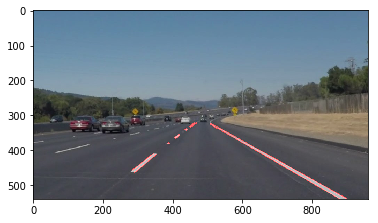

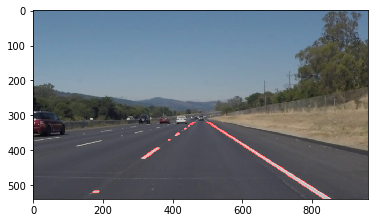

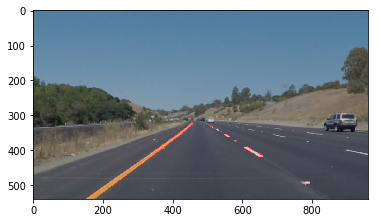

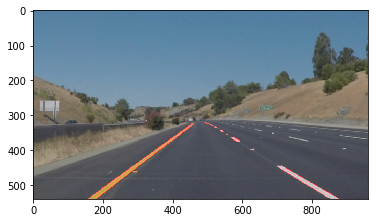

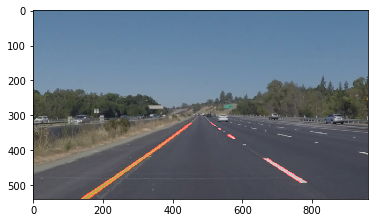

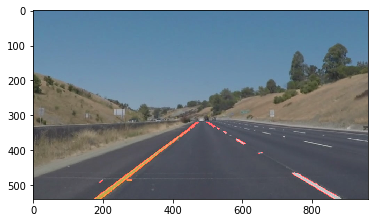

In [7]:
import os
os.listdir("test_images/")

for test_image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + test_image)
    result, lines = detect_lanes_from_image_path('test_images/' + test_image, 0)
    plt.imshow(result)
    plt.show()
    
# import glob
# paths = glob.glob('test_images/*.jpg')

# for i,image_path in enumerate(paths):
    # result, lines = detect_lanes_from_image_path(image_path,0)
    # plt.subplot(3,2,i+1)
    # plt.imshow(result)
    # mpimg.imsave('test_images/detected/'+image_path[12:-4]+'_detected.jpg', result)